In [66]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

## Data Preprocessing - Store Sales

### train.csv and test.csv

In [ ]:
# Loading Data
train = pd.read_csv("Data/train.zip", parse_dates=["date"])
test = pd.read_csv("Data/test.csv", parse_dates=["date"])
test_ids = test["id"]

train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [69]:
family_list = train["family"].unique()
stores_list = train["store_nbr"].unique()

train_start = train["date"].min()
train_end = train["date"].max()
num_period_days_train = (train_end - train_start).days + 1
num_train_days = train["date"].nunique()

test_start = test["date"].min().date()
test_end = test["date"].max().date()
num_period_days_test = (test_end - test_start).days + 1
num_test_days = test["date"].nunique()

print(f"Number of families: {len(family_list)}")
print(f"Number of stores: {len(stores_list)}\n")
print(f"Train period: {train_start.date()} to {train_end.date()} - {num_period_days_train} days")
print(f"Number of train days: {num_train_days}\n")
print(f"Test period: {test_start} to {test_end} - {num_period_days_test} days")
print(f"Number of test days: {num_test_days}")

Number of families: 33
Number of stores: 54

Train period: 2013-01-01 to 2017-08-15 - 1688 days
Number of train days: 1684

Test period: 2017-08-16 to 2017-08-31 - 16 days
Number of test days: 16


In [70]:
# We don't have training data for Christmas days (Store are closed)
missing_train_dates = pd.date_range(train_start, train_end).difference(train["date"].unique())
missing_train_dates = missing_train_dates.strftime('%Y-%m-%d').to_list()

print(f"Missing dates: {', '.join(missing_train_dates)}")

Missing dates: 2013-12-25, 2014-12-25, 2015-12-25, 2016-12-25


In [71]:
# Reindexing train data to have all dates including Christmas days (Closed days with no sales and promotions)
new_idx = pd.MultiIndex.from_product([pd.date_range(train_start, train_end), train["store_nbr"].unique(), train["family"].unique()], names=["date", "store_nbr", "family"])
train = train.set_index(["date", "store_nbr", "family"]).reindex(new_idx).reset_index()
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0)

print(f"Number of missing dates: {train.isnull().sum().sum()}")

Number of missing dates: 0


### store.csv

In [72]:
stores = pd.read_csv("Data/stores.csv")
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [73]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [74]:
num_stores = len(stores["store_nbr"].unique())
num_cities = len(stores["city"].unique())
num_states = len(stores["state"].unique())
num_types = len(stores["type"].unique())

print(f"Number of stores: {num_stores}")
print(f"Number of cities: {num_cities}")
print(f"Number of states: {num_states}")
print(f"Number of types: {num_types}")

Number of stores: 54
Number of cities: 22
Number of states: 16
Number of types: 5


### holiday_events.csv

In [75]:
holidays = pd.read_csv("Data/holidays_events.csv", parse_dates=["date"])
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [76]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [77]:
types = holidays['type'].unique()
locality = holidays['locale'].unique()

print(f"Localities of holidays: {', '.join(locality)}")
print(f"Types of holidays: {', '.join(types)}")

Localities of holidays: Local, Regional, National
Types of holidays: Holiday, Transfer, Additional, Bridge, Work Day, Event


In [78]:
national_locale_name = holidays[holidays["locale"]=="National"]["locale_name"].unique().tolist()
region_locale_name = holidays[holidays["locale"]=="Regional"]["locale_name"].unique().tolist()
local_locale_name = holidays[holidays["locale"]=="Local"]["locale_name"].unique().tolist()

print(f"National holiday places: {', '.join(national_locale_name)}")
print(f"Region holiday places: {', '.join(region_locale_name)}")
print(f"Local holiday places: {', '.join(local_locale_name)}")

National holiday places: Ecuador
Region holiday places: Cotopaxi, Imbabura, Santo Domingo de los Tsachilas, Santa Elena
Local holiday places: Manta, Cuenca, Libertad, Riobamba, Puyo, Guaranda, Latacunga, Machala, Santo Domingo, El Carmen, Cayambe, Esmeraldas, Ambato, Ibarra, Quevedo, Quito, Loja, Salinas, Guayaquil


In [79]:
# Simplifying holiday description
def apply_cleaning(text):
    
    if pd.isna(text): return ""
    text = text.lower()
    
    if "futbol" in text:
        return "futbol"
        
    text = re.sub(loc_pattern, "", text)
    text = re.sub(noise_pattern, "", text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

cities = set(stores['city'].str.lower().unique())
states = set(stores['state'].str.lower().unique())

locations_to_remove = list(cities | states)
loc_pattern = r'\b(' + '|'.join(map(re.escape, locations_to_remove)) + r')\b'

noise_pattern = r'[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b'

holidays["description"] = holidays["description"].apply(apply_cleaning)

holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


In [80]:
# Cleaning transferred holidays
holidays = holidays[holidays["transferred"] == False]

# Getting work days
work_days = holidays[holidays["type"] == "Work Day"]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}).reset_index(drop=True)
work_days["work_day"] = work_days["work_day"].notna().astype(int)
holidays = holidays[holidays["type"] != "Work Day"].reset_index(drop=True)

# Getting local holidays
local_holidays = holidays[holidays["locale"]=="Local"]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)
local_holidays = local_holidays.drop_duplicates()
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc", dtype=int)

# Getting regional holidays
regional_holidays = holidays[holidays["locale"] =="Regional"]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "state"}).reset_index(drop=True)
duplicados = regional_holidays[regional_holidays.duplicated(keep=False)]
regional_holidays = pd.get_dummies(regional_holidays, columns=["description"], prefix="reg", dtype=int)

# Getting national holidays
national_holidays = holidays[holidays["locale"] =="National"]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays.drop_duplicates()
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
national_holidays = national_holidays.groupby("date").sum().reset_index()

### oil.csv

In [81]:
oil = pd.read_csv("Data/oil.csv", parse_dates=["date"])
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [82]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [83]:
# We don't have oil price on weekends
missing_oil_dates = pd.date_range(start = oil['date'].min(), end = oil['date'].max()).difference(oil["date"])

print(f"Number of days missing oil price: {len(missing_oil_dates)}")
print(f"Number of weekend days in train data: {(pd.date_range(train_start, test_end).weekday >= 5).sum()}")

Number of days missing oil price: 486
Number of weekend days in train data: 486


In [84]:
# Filling missing values in oil data for weekends and missing values with previous values or next values if not possible
oil["date"] = pd.to_datetime(oil["date"])
oil = oil.set_index("date")

new_idx = pd.date_range(start = oil.index.min(), end = oil.index.max())
oil = oil.reindex(new_idx)

oil = oil.ffill().bfill()

oil = oil.reset_index().rename(columns={"index": "date"})

print(f"Number of missing values in oil data: {oil['dcoilwtico'].isnull().sum()}")

Number of missing values in oil data: 0


### transactions.csv

In [85]:
transactions = pd.read_csv("Data/transactions.csv", parse_dates=["date"])
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [86]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [87]:
num_zero_sales = (train.groupby(["date", "store_nbr"])["sales"].sum() == 0).sum()
total_expected_records = num_stores * num_period_days_train
current_records = len(transactions)

print(f"Expected number of records (Number of Stores * Days): {total_expected_records}\n")
print(f"Number of current records in transactions.csv: {current_records}")
print(f"Number with zero sales: {num_zero_sales}")
print(f"Number with missing sales: {total_expected_records - current_records - num_zero_sales}")

Expected number of records (Number of Stores * Days): 91152

Number of current records in transactions.csv: 83488
Number with zero sales: 7546
Number with missing sales: 118


In [88]:
# Filling missing values in transactions looking if the store is open or not
store_sales = train.groupby(["date", "store_nbr"])["sales"].sum().reset_index()

sales_and_transactions = store_sales.merge(transactions, on=["date", "store_nbr"], how="left")
sales_and_transactions = sales_and_transactions.sort_values(["store_nbr", "date"])

close_mask = (sales_and_transactions["sales"] == 0) & (sales_and_transactions["transactions"].isna())
sales_and_transactions.loc[close_mask, "transactions"] = 0

sales_and_transactions["transactions"] = sales_and_transactions.groupby("store_nbr")["transactions"].transform(
    lambda x: x.interpolate(method="linear", limit_direction="both"))

transactions = sales_and_transactions[["date", "store_nbr", "transactions"]]

print(f"Number of current records after filling missing values: {sales_and_transactions.shape[0]}")

Number of current records after filling missing values: 91152


### Feature Engineering

In [89]:
# Adding day of the week, day, month, year, is weekend, pay day
train['day_of_week'] = train['date'].dt.dayofweek
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
train['is_payday'] = ((train['day_of_week'] == 15) | (train['date'].dt.is_month_end)).astype(int)

test['day_of_week'] = test['date'].dt.dayofweek
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['is_weekend'] = (test['day_of_week'] >= 5).astype(int)
test['is_payday'] = ((test['day_of_week'] == 15) | (test['date'].dt.is_month_end)).astype(int)

In [90]:
# Creating oil features with moving average and filling first values with previous values
oil["oil_ma7"] = oil["dcoilwtico"].rolling(window=7).mean()
oil["oil_ma30"] = oil["dcoilwtico"].rolling(window=30).mean()

oil["oil_ma7"] = oil["oil_ma7"].bfill()
oil["oil_ma30"] = oil["oil_ma30"].bfill()

In [91]:
# Creating lags for transactions data to use it in prediction for train and test data
new_idx = pd.MultiIndex.from_product([pd.date_range(transactions["date"].min(), test_end), train["store_nbr"].unique()], names=["date", "store_nbr"])
transactions = transactions.set_index(["date", "store_nbr"]).reindex(new_idx).reset_index()

transactions['transactions_lag_16'] = transactions.groupby("store_nbr")["transactions"].shift(16)
transactions['transactions_lag_21'] = transactions.groupby("store_nbr")["transactions"].shift(21)
transactions['transactions_lag_28'] = transactions.groupby("store_nbr")["transactions"].shift(28)
transactions['transactions_lag_30'] = transactions.groupby("store_nbr")["transactions"].shift(30)
transactions['transactions_lag_365'] = transactions.groupby("store_nbr")["transactions"].shift(365)

transactions['transactions_ma7_shift_16'] = transactions.groupby("store_nbr")["transactions"].transform(
    lambda x: x.shift(16).rolling(window=7).mean())
transactions['transactions_ma30_shift_16'] = transactions.groupby("store_nbr")["transactions"].transform(
    lambda x: x.shift(16).rolling(window=30).mean())

In [92]:
# Creating lags for sales data to use it in prediction with the log transformation
train["sales_lg"] = np.log1p(train["sales"])

df_total = pd.concat([train, test], ignore_index=True)
df_total = df_total.sort_values(["store_nbr", "family", "date"])

df_total['sales_lag_16'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(16)
df_total['sales_lag_21'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(21)
df_total['sales_lag_28'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(28)
df_total['sales_lag_30'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(30)
df_total['sales_lag_365'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(365)

df_total["sales_ma7_shift16"] = df_total.groupby(["store_nbr", "family"])["sales_lg"].transform(
        lambda x: x.shift(16).rolling(window=7).mean())
df_total["sales_ma30_shift16"] = df_total.groupby(["store_nbr", "family"])["sales_lg"].transform(
        lambda x: x.shift(16).rolling(window=30).mean())

In [93]:
# Dividing data into train and test again and cleaning them
train = df_total[df_total["date"] <= train_end].copy()
test = df_total[df_total["date"] > train_end].copy()

In [94]:
# Merging stores data with train and test datasets
train = train.merge(stores, on="store_nbr", how="left")
test = test.merge(stores, on="store_nbr", how="left")

# Merging oil data with train and test datasets
train = train.merge(oil, on="date", how="left")
test = test.merge(oil, on="date", how="left")

# Merging Transactions data with train dataset
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")

# Merging National holidays data with train and test datasets
train = train.merge(national_holidays, on="date", how="left")
test = test.merge(national_holidays, on="date", how="left")

# Merging Regional holidays data with train and test datasets
train = train.merge(regional_holidays, on=["date", "state"], how="left")
test = test.merge(regional_holidays, on=["date", "state"], how="left")

# Merging Local holidays data with train and test datasets
train = train.merge(local_holidays, on=["date", "city"], how="left")
test = test.merge(local_holidays, on=["date", "city"], how="left")

# Merging Work Days data with train and test datasets
train = train.merge(work_days, on="date", how="left")
test = test.merge(work_days, on="date", how="left")

# Filling holiday columns nan with 0
cols_festivos = [c for c in test.columns if c.startswith('nat_') or c.startswith('loc_') or c.startswith('reg_') or 'work_day' in c]
test[cols_festivos] = test[cols_festivos].fillna(0)
train[cols_festivos] = train[cols_festivos].fillna(0)

## Data Visualization

### Evolution of transactions

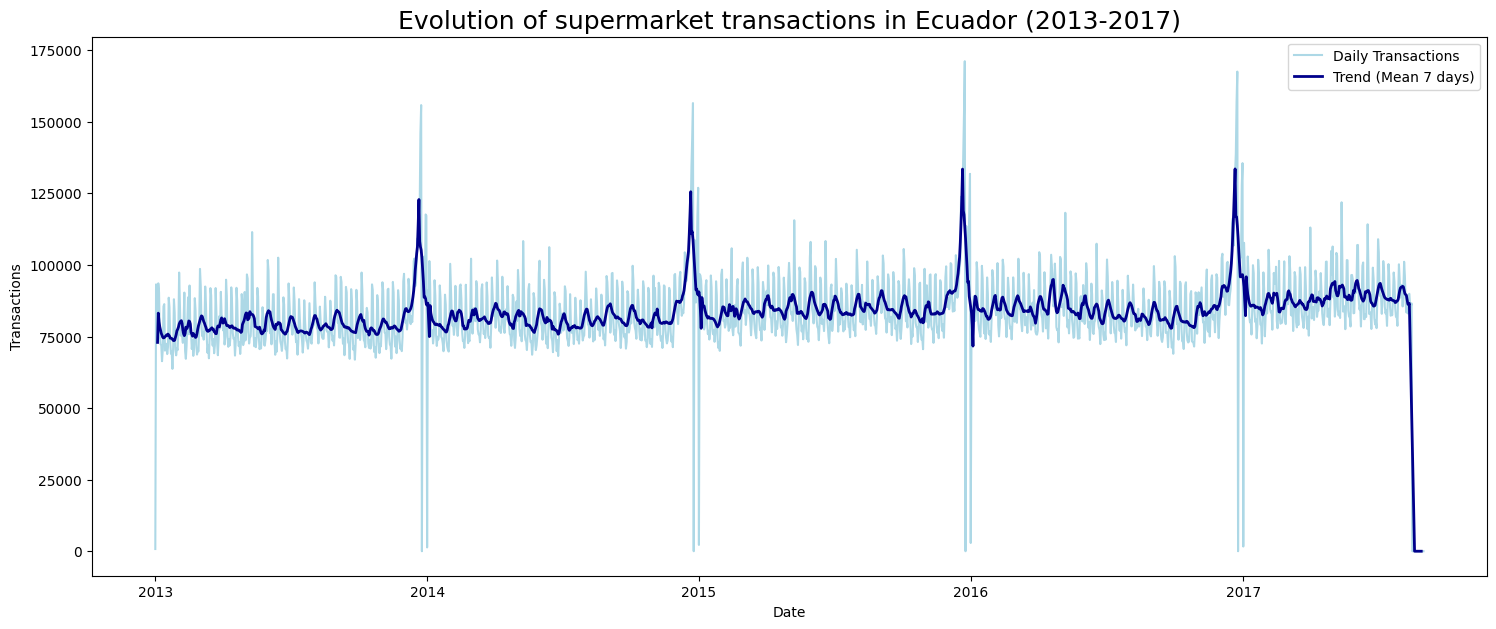

In [95]:
daily_total = transactions.groupby("date")["transactions"].sum().reset_index()
daily_total["rolling_7"] = daily_total["transactions"].rolling(window=7, center=True).mean()

plt.figure(figsize=(18, 7))

sns.lineplot(data=daily_total, x="date", y="transactions", color='lightblue', label='Daily Transactions')
sns.lineplot(data=daily_total, x="date", y="rolling_7", color='darkblue', linewidth=2, label='Trend (Mean 7 days)')

plt.title("Evolution of supermarket transactions in Ecuador (2013-2017)", fontsize=18)
plt.ylabel("Transactions")
plt.xlabel("Date")
plt.legend()

plt.show()

### Evolution of sales

NameError: name 'ticker' is not defined

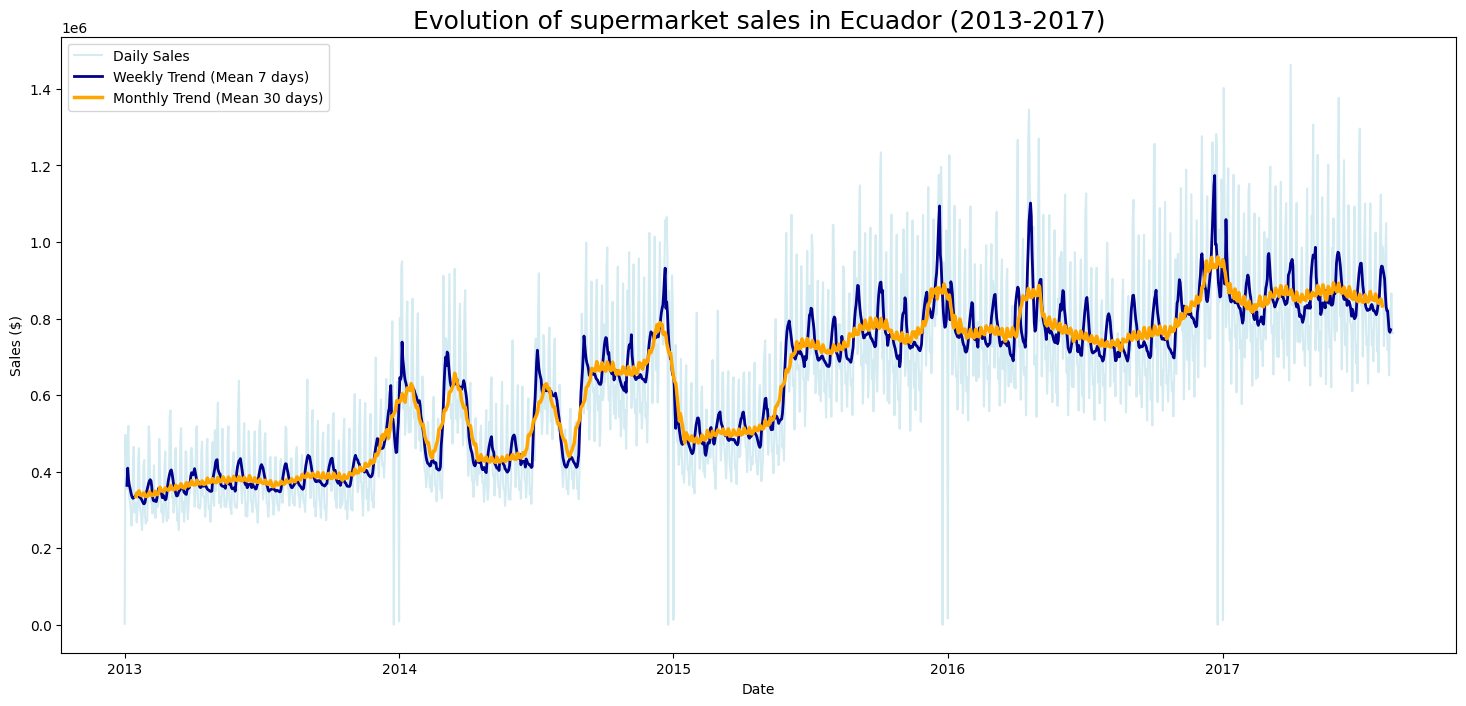

In [96]:
daily_sales = train.groupby("date")["sales"].sum().reset_index()
daily_sales["rolling_7"] = daily_sales["sales"].rolling(window=7, center=True).mean()
daily_sales["rolling_30"] = daily_sales["sales"].rolling(window=30, center=True).mean()

plt.figure(figsize=(18, 8))

sns.lineplot(data=daily_sales, x="date", y="sales", color="lightblue", alpha=0.5, label="Daily Sales")
sns.lineplot(data=daily_sales, x="date", y="rolling_7", color="darkblue", linewidth=2, label="Weekly Trend (Mean 7 days)")
sns.lineplot(data=daily_sales, x="date", y="rolling_30", color="orange", linewidth=2.5, label="Monthly Trend (Mean 30 days)")

plt.title("Evolution of supermarket sales in Ecuador (2013-2017)", fontsize=18)
plt.ylabel("Sales ($)")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.legend()

plt.show()

### Evolution of sales vs transactions

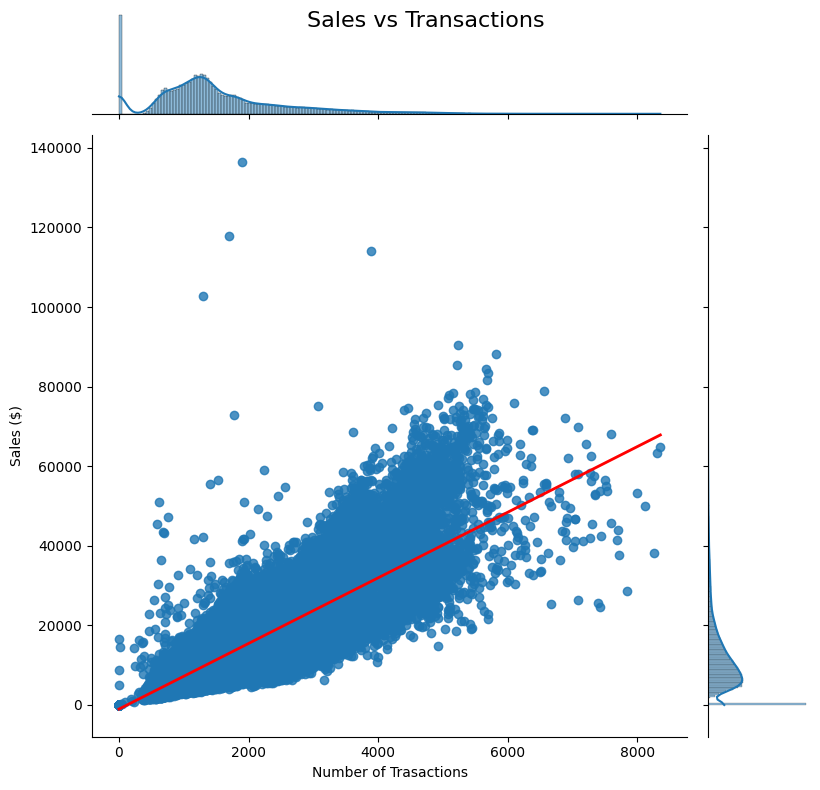

In [ ]:
df_scatter = train.groupby(["date", "store_nbr"])["sales"].sum().reset_index().merge(transactions, on=["date", "store_nbr"], how="inner")

sns.jointplot(data=df_scatter, x="transactions", y="sales", kind="reg", height=8, line_kws={'color': 'red', 'linewidth': 2})

plt.suptitle("Sales vs Transactions", fontsize=16)
plt.xlabel("Number of Trasactions")
plt.ylabel("Sales ($)")

plt.show()

### Sales by day of week

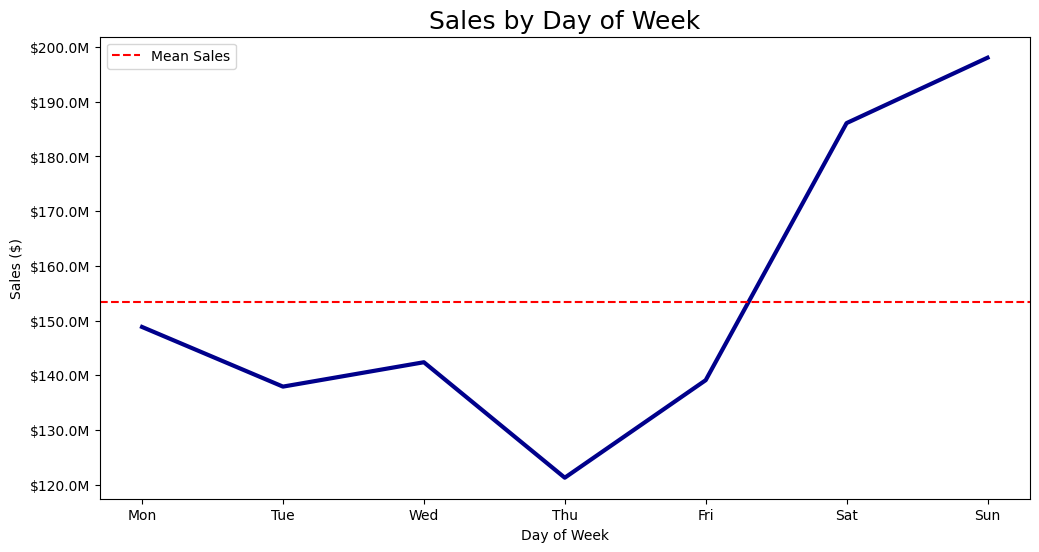

In [ ]:
week_day_sales = train.groupby("day_of_week")["sales"].sum().reset_index()
mean_sales = week_day_sales["sales"].mean()

plt.figure(figsize=(12, 6))

sns.lineplot(x="day_of_week", y="sales", data=week_day_sales, color='darkblue', linewidth=3)
plt.axhline(week_day_sales["sales"].mean(), color='red', linestyle='--', label='Mean Sales')

plt.title("Sales by Day of Week", fontsize=18)
plt.xlabel("Day of Week")
plt.ylabel("Sales ($)")
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.legend()

plt.show()

### Sales by month

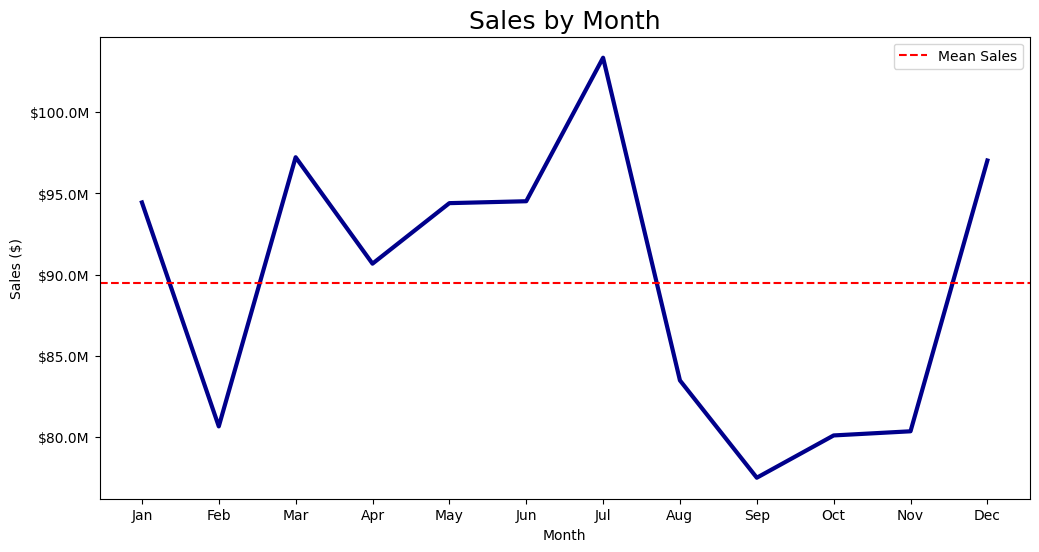

In [ ]:
month_sales = train.groupby("month")["sales"].sum().reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(x="month", y="sales", data=month_sales, color='darkblue', linewidth=3)
plt.axhline(month_sales["sales"].mean(), color='red', linestyle='--', label="Mean Sales")

plt.title("Sales by Month", fontsize=18)
plt.xlabel("Month")
plt.ylabel("Sales ($)")
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.legend()

plt.show()

### Sales by family product

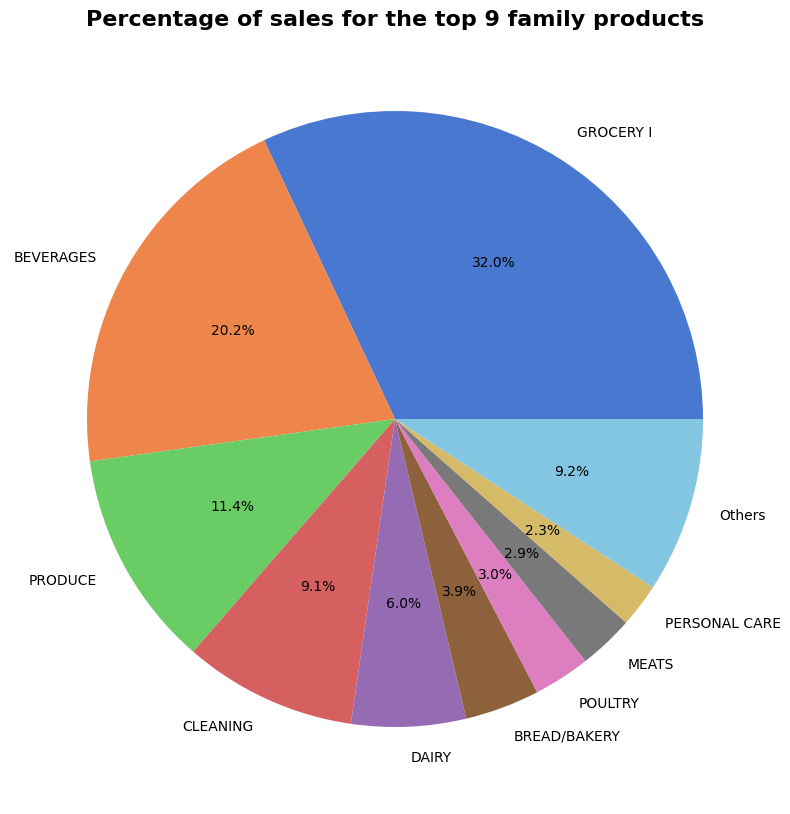

In [ ]:
ranking_families = train.groupby("family")["sales"].sum().sort_values(ascending=False)
top = 9
ranking_families = pd.concat([ranking_families.head(top), pd.Series({'Others': ranking_families.iloc[top:].sum()})])

plt.figure(figsize=(10, 10))

plt.pie(ranking_families, labels=ranking_families.index, autopct='%1.1f%%', colors=sns.color_palette("muted", n_colors=top+1))

plt.title(f"Percentage of sales for the top {top} family products", fontsize=16, fontweight='bold')

plt.show()

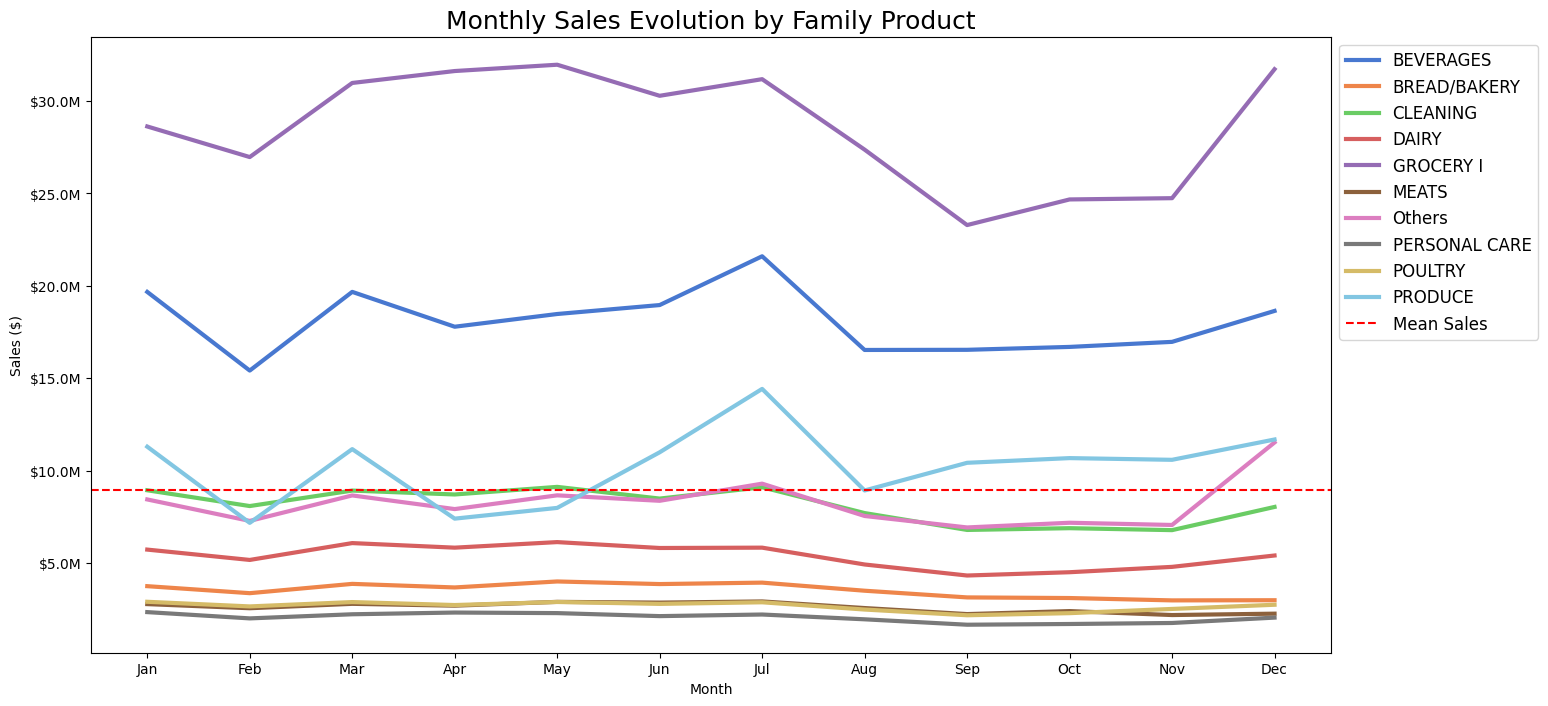

In [ ]:
top_families = ranking_families.head(top).index.tolist()

train_viz = train.copy()
train_viz["family_group"] = train_viz["family"].astype(str).apply(lambda x: x if x in top_families else "Others")
monthly_evolution = train_viz.groupby(["month", "family_group"])["sales"].sum().reset_index()

plt.figure(figsize=(16, 8))

sns.lineplot(data=monthly_evolution, x="month", y="sales", hue="family_group", linewidth=3, palette="muted")
plt.axhline(monthly_evolution["sales"].mean(), color='red', linestyle='--', label="Mean Sales",)

plt.title("Monthly Sales Evolution by Family Product", fontsize=18)
plt.xlabel("Month")
plt.ylabel("Sales ($)")
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=12)

plt.show()

### Evolution of oil price

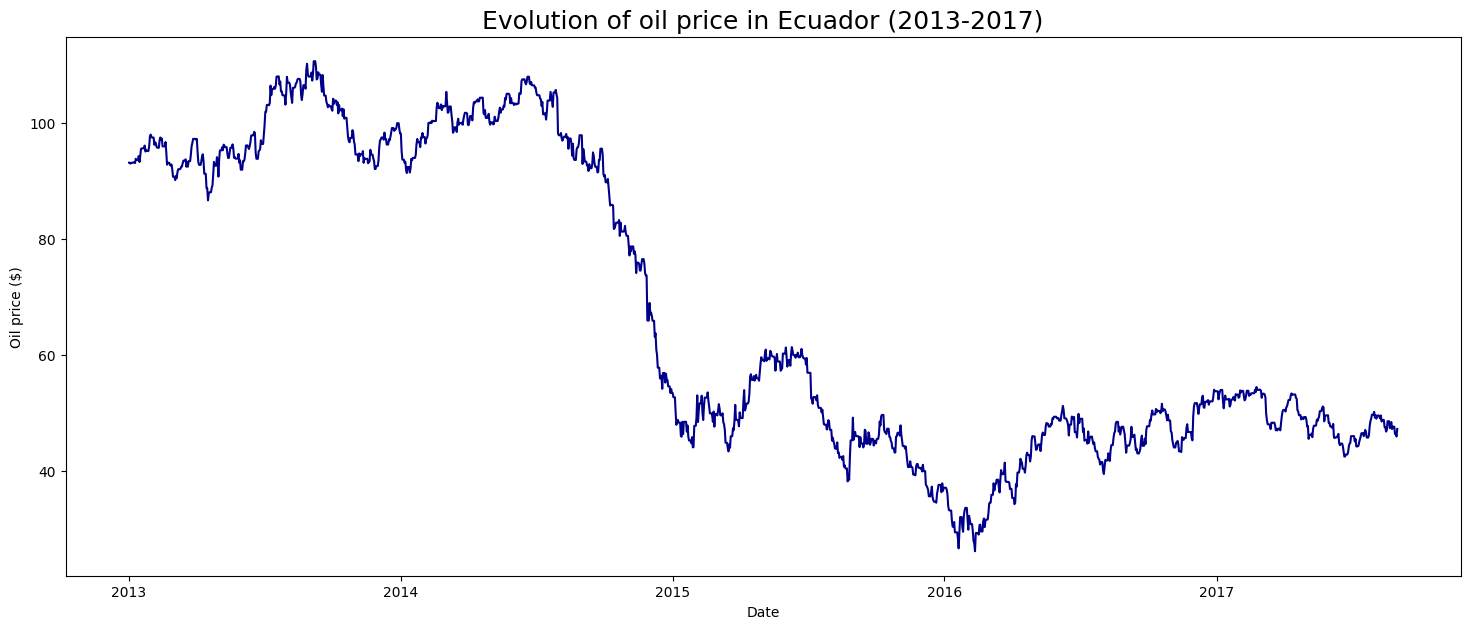

In [ ]:
plt.figure(figsize=(18, 7))

sns.lineplot(data=oil, x="date", y="dcoilwtico", color='darkblue')

plt.title("Evolution of oil price in Ecuador (2013-2017)", fontsize=18)
plt.ylabel("Oil price ($)")
plt.xlabel("Date")

plt.show()

### Sales comparison with oil price

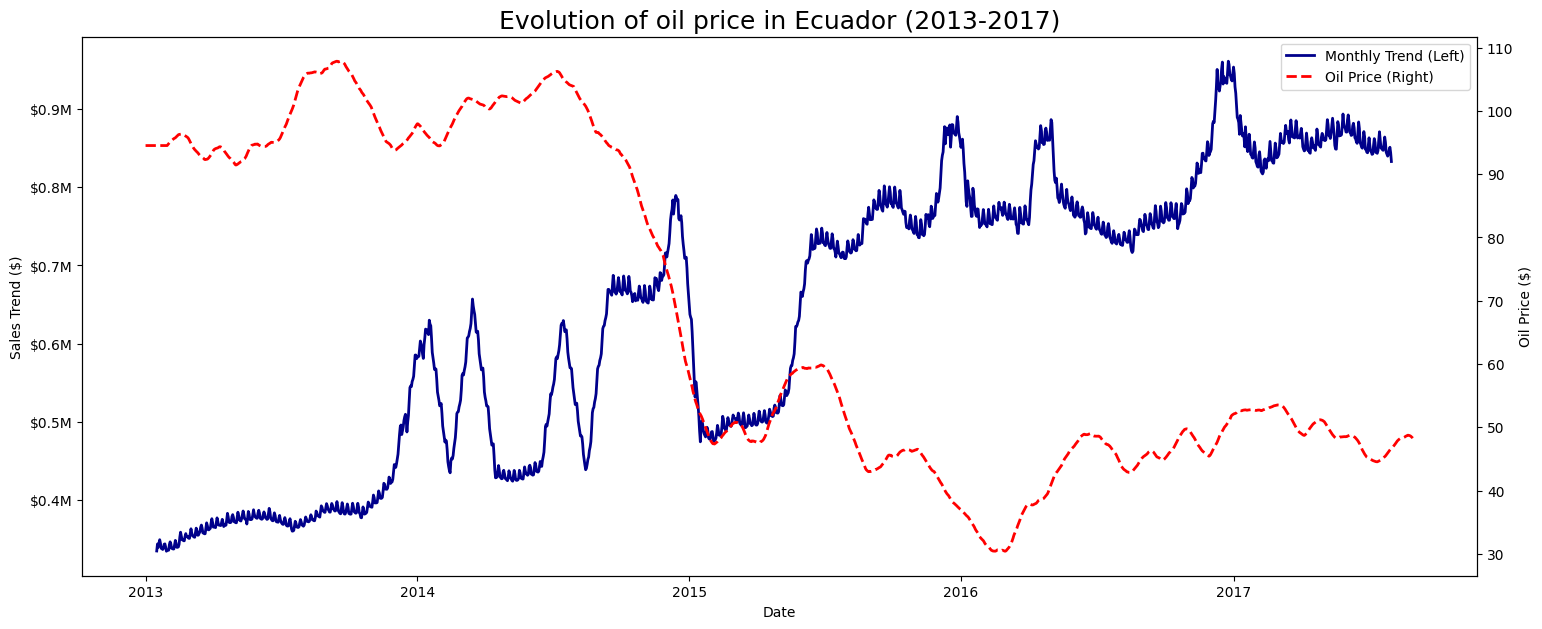

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 7))

sns.lineplot(data=daily_sales, x="date", y="rolling_30", color="darkblue", ax=ax1, linewidth=2, label="Monthly Trend (Left)")

ax1.set_ylabel("Sales Trend ($)")
ax1.set_xlabel("Date")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

ax2 = ax1.twinx()

sns.lineplot(data=oil, x="date", y="oil_ma30", color="red", ax=ax2, linewidth=2, linestyle='--', label="Oil Price (Right)")

ax2.set_ylabel("Oil Price ($)")
ax2.get_legend().remove()

plt.title("Evolution of oil price in Ecuador (2013-2017)", fontsize=18)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

plt.show()

### Mean sales on holidays vs non-holidays

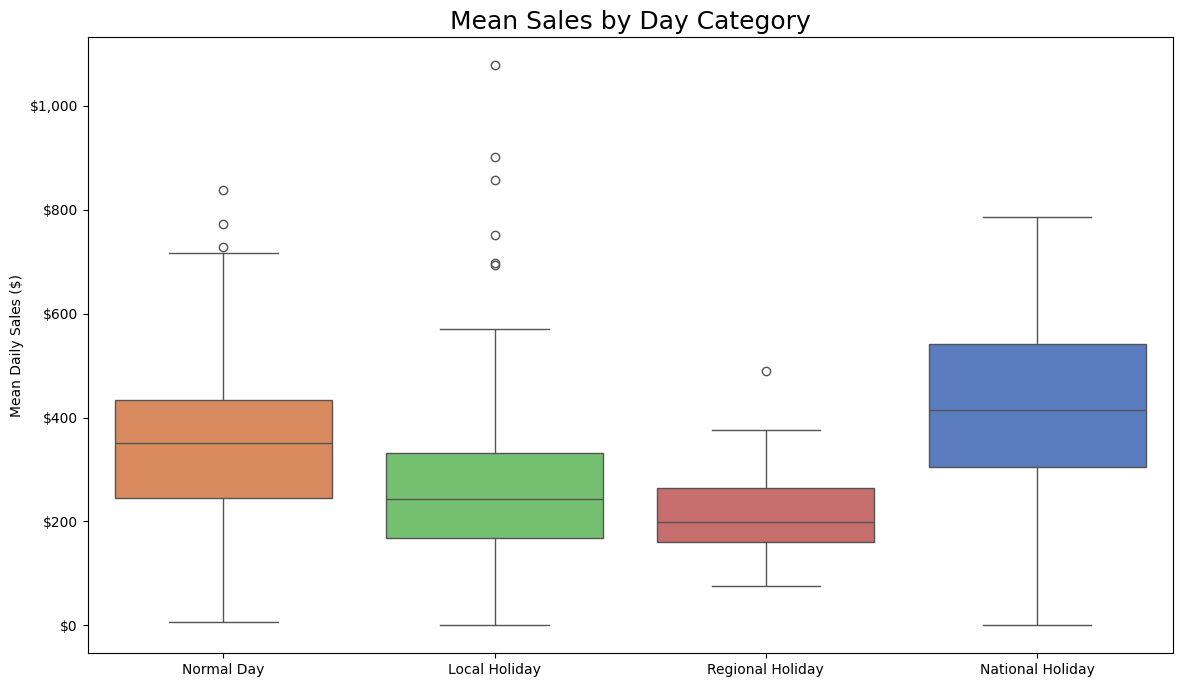

In [ ]:
df_viz = train.copy()
df_viz["category"] = "Normal Day"

nat_cols = [c for c in df_viz.columns if c.startswith('nat_')]
reg_cols = [c for c in df_viz.columns if c.startswith('reg_')]
loc_cols = [c for c in df_viz.columns if c.startswith('loc_')]

if loc_cols:
    df_viz.loc[df_viz[loc_cols].sum(axis=1) > 0, "category"] = "Local Holiday"

if reg_cols:
    df_viz.loc[df_viz[reg_cols].sum(axis=1) > 0, "category"] = "Regional Holiday"

if nat_cols:
    df_viz.loc[df_viz[nat_cols].sum(axis=1) > 0, "category"] = "National Holiday"

daily_avg_store_sales = df_viz.groupby(["date", "category"])["sales"].mean().reset_index()

plt.figure(figsize=(14, 8))

orden = ["Normal Day", "Local Holiday", "Regional Holiday", "National Holiday"]

sns.boxplot(data=daily_avg_store_sales, x="category", y="sales", hue="category", palette="muted", order=orden)

plt.title("Mean Sales by Day Category", fontsize=18)
plt.ylabel("Mean Daily Sales ($)")
plt.xlabel("")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.show()

## Model Development and Training

In [ ]:
# Dividing data for models and cleaning useless and nan records 
# first year data will be deleted intentionally due to the use of lags
train_clean = train.dropna().copy()

cols_to_convert = [c for c in train_clean.select_dtypes(include=['object']).columns if c != 'date']

for col in cols_to_convert:
    train_clean[col] = train_clean[col].astype("category")
    test[col] = test[col].astype("category")

val_day = 15
train_end = train_clean['date'].max()
val_start = train_end - pd.Timedelta(days=val_day)

drop_cols = ['date', 'sales', 'sales_lg', 'transactions']

mask_train = train_clean['date'] < val_start
X_train_model = train_clean.loc[mask_train].drop(columns=drop_cols)
y_train_model = train_clean.loc[mask_train, 'sales_lg']

mask_val = train_clean['date'] >= val_start
X_val_model = train_clean.loc[mask_val].drop(columns=drop_cols)
y_val_model = train_clean.loc[mask_val, 'sales_lg']


X_test_model = test.drop(columns=drop_cols)

print(f"Train: {X_train_model.shape}")
print(f"Validation: {X_val_model.shape}")
print(f"Test:  {X_test_model.shape}")

Train: (2329074, 49)
Validation: (28512, 49)
Test:  (28512, 49)


### XGBoost

In [118]:
# Training XGBoost model
model_xgb = xgb.XGBRegressor(
    n_estimators=1500, learning_rate=0.05, max_depth=10, early_stopping_rounds=50,
    subsample=0.7, colsample_bytree=0.7, n_jobs=-1, tree_method='hist', enable_categorical=True)

model_xgb.fit(X_train_model, y_train_model, eval_set=[(X_train_model, y_train_model), (X_val_model, y_val_model)], verbose=10)
print(f"\n XGBoost RMSE Val: {model_xgb.best_score:.5f}")

[0]	validation_0-rmse:2.54854	validation_1-rmse:2.44972
[10]	validation_0-rmse:1.60251	validation_1-rmse:1.51292
[20]	validation_0-rmse:1.05510	validation_1-rmse:0.96911
[30]	validation_0-rmse:0.75495	validation_1-rmse:0.67318
[40]	validation_0-rmse:0.59953	validation_1-rmse:0.52407
[50]	validation_0-rmse:0.52194	validation_1-rmse:0.45799
[60]	validation_0-rmse:0.48318	validation_1-rmse:0.43098
[70]	validation_0-rmse:0.46123	validation_1-rmse:0.42091
[80]	validation_0-rmse:0.44841	validation_1-rmse:0.41636
[90]	validation_0-rmse:0.43822	validation_1-rmse:0.41429
[100]	validation_0-rmse:0.42913	validation_1-rmse:0.41318
[110]	validation_0-rmse:0.42225	validation_1-rmse:0.41193
[120]	validation_0-rmse:0.41734	validation_1-rmse:0.41076
[130]	validation_0-rmse:0.41279	validation_1-rmse:0.40966
[140]	validation_0-rmse:0.40826	validation_1-rmse:0.40903
[150]	validation_0-rmse:0.40452	validation_1-rmse:0.40808
[160]	validation_0-rmse:0.40191	validation_1-rmse:0.40737
[170]	validation_0-rmse:0

### LightGBM

In [119]:
# Training LightGBM model
model_lgbm = lgb.LGBMRegressor(
    n_estimators=1500, learning_rate=0.05, num_leaves=31,  metric='rmse',
    subsample=0.7, colsample_bytree=0.7, n_jobs=-1)

callbacks = [lgb.early_stopping(50, verbose=False), lgb.log_evaluation(period=10)]
model_lgbm.fit(X_train_model, y_train_model, eval_set=[(X_train_model, y_train_model), (X_val_model, y_val_model)], callbacks=callbacks)

lgbm_pred_val = model_lgbm.predict(X_val_model)
lgbm_rmse = np.sqrt(mean_squared_error(y_val_model, lgbm_pred_val))
print(f"\n LightGBM RMSE Val: {lgbm_rmse:.5f}")

[10]	training's rmse: 1.71883	valid_1's rmse: 1.60654
[20]	training's rmse: 1.18141	valid_1's rmse: 1.05035
[30]	training's rmse: 0.891276	valid_1's rmse: 0.742961
[40]	training's rmse: 0.74091	valid_1's rmse: 0.585147
[50]	training's rmse: 0.66144	valid_1's rmse: 0.51525
[60]	training's rmse: 0.617276	valid_1's rmse: 0.484354
[70]	training's rmse: 0.585706	valid_1's rmse: 0.471183
[80]	training's rmse: 0.565728	valid_1's rmse: 0.466395
[90]	training's rmse: 0.551217	valid_1's rmse: 0.462443
[100]	training's rmse: 0.538461	valid_1's rmse: 0.458446
[110]	training's rmse: 0.528831	valid_1's rmse: 0.45223
[120]	training's rmse: 0.518998	valid_1's rmse: 0.450474
[130]	training's rmse: 0.510776	valid_1's rmse: 0.449505
[140]	training's rmse: 0.503854	valid_1's rmse: 0.447585
[150]	training's rmse: 0.499396	valid_1's rmse: 0.447026
[160]	training's rmse: 0.49525	valid_1's rmse: 0.446762
[170]	training's rmse: 0.491773	valid_1's rmse: 0.445698
[180]	training's rmse: 0.488727	valid_1's rmse: 0

### Ensemble model

In [130]:
# Looking to find the best weights for the ensemble
val_pred_xgb = model_xgb.predict(X_val_model)
val_pred_lgbm = model_lgbm.predict(X_val_model)

best_weights = (0, 0)
best_error = np.inf

for weight_xgb in np.arange(0, 1.01, 0.05):
    weight_lgbm = 1 - weight_xgb
    
    pred_ens = (val_pred_xgb * weight_xgb) + (val_pred_lgbm * weight_lgbm)
    error = np.sqrt(mean_squared_error(y_val_model, pred_ens))
    
    if error < best_error:
        best_error = error
        best_weights = (weight_xgb, weight_lgbm)

print(f"XGBoost:  {model_xgb.best_score:.5f}")
print(f"LGBM:     {lgbm_rmse:.5f}")
print(f"BEST ENSEMBLE: {best_error:.5f} (XGB: {best_weights[0]:.2f} - LGBM: {best_weights[1]:.2f})")

XGBoost:  0.40005
LGBM:     0.40955
BEST ENSEMBLE: 0.39971 (XGB: 0.85 - LGBM: 0.15)


In [ ]:
# Function to create submission for a given model
def submission_model(model):
    preds_log = None
    
    if model == "xgb":
        preds_log = model_xgb.predict(X_test_model)

    elif model == "lgbm":
        preds_log = model_lgbm.predict(X_test_model)

    elif model == "ensemble":
        preds_log_xgb = model_xgb.predict(X_test_model)
        preds_log_lgbm = model_lgbm.predict(X_test_model)
        preds_log = (preds_log_xgb * best_weights[0]) + (preds_log_lgbm * best_weights[1])

    preds_real = np.expm1(preds_log)
    preds_real = np.maximum(preds_real, 0)

    submission = pd.DataFrame({'id': test_ids, 'sales': preds_real})
    print(submission.head())
    submission.to_csv(f'submission_{model}.csv', index=False) 

In [166]:
# Generating submission files for all models 
submission_model("xgb")
submission_model("lgbm")
submission_model("ensemble")

           id     sales
0     3000888  4.413379
1782  3002670  3.618891
3564  3004452  4.055210
5346  3006234  3.665780
7128  3008016  1.846938
           id     sales
0     3000888  4.211560
1782  3002670  3.805735
3564  3004452  4.546916
5346  3006234  4.937807
7128  3008016  2.189246
           id     sales
0     3000888  4.382615
1782  3002670  3.646448
3564  3004452  4.126088
5346  3006234  3.837595
7128  3008016  1.895840


## Conclusions and Insights